In [1]:
import os

# 设置环境变量
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

# 打印环境变量以确认设置成功
print(os.environ.get('HF_ENDPOINT'))

https://hf-mirror.com


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer
import evaluate
import numpy as np
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification


# 假设你的JSON文件名为 'data.json' 并且每行是一个独立的JSON对象
raw_datasets = load_dataset('paws-x', 'en')  # 或者指定特定语言如 'zh' 表示中文,https://huggingface.co/datasets/google-research-datasets/paws-x

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
#tokenizer.pad_token = tokenizer.eos_token


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"])


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/home/maris/miniconda3/envs/dnagpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 32808.11 examples/s]


In [3]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [4]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': (predictions==labels).sum() / len(labels)}

In [5]:
training_args = TrainingArguments(
    output_dir="ds_job_dna_2222",
    learning_rate=1e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_ratio=0.1,
    optim='adamw_torch',
    weight_decay=0.0,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    num_train_epochs=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True
)

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-cased", num_labels=2)
#model.config.pad_token_id = model.config.eos_token_id

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/home/maris/miniconda3/envs/dnagpt/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_88736/571955.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[2024-12-11 21:16:32,413] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/maris/miniconda3/envs/dnagpt/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/maris/miniconda3/envs/dnagpt/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda-12/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/maris/miniconda3/envs/dnagpt/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda-12/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/maris/miniconda3/envs/dnagpt/compiler_compat/ld: /usr/local/cuda-12/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/home/maris/miniconda3/envs/dnagpt/compiler_compat/ld: /usr/local/cuda-12/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/home/maris/miniconda3/envs/dnagpt/compiler_compat/ld: /usr/local/cuda-12/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/home/maris/miniconda3/envs/dnagpt/compiler_

In [6]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.411200,0.259740,0.915500
2,0.190500,0.223145,0.934000
3,0.143500,0.308454,0.936500
4,0.114700,0.335784,0.928000


TrainOutput(global_step=9884, training_loss=0.2149687812956467, metrics={'train_runtime': 528.5786, 'train_samples_per_second': 373.84, 'train_steps_per_second': 18.699, 'total_flos': 8074171691925900.0, 'train_loss': 0.2149687812956467, 'epoch': 4.0})

In [7]:
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.9385, 'f1': 0.9320066334991708}

In [8]:
raw_datasets_fr = load_dataset('paws-x', 'fr')  # 或者指定特定语言如 'zh' 表示中文,https://huggingface.co/datasets/google-research-datasets/paws-x
tokenized_datasets_fr = raw_datasets_fr.map(tokenize_function, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 29651.26 examples/s]


In [9]:
predictions = trainer.predict(tokenized_datasets_fr["test"])
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.874, 'f1': 0.8577878103837472}

In [10]:
raw_datasets_de = load_dataset('google-research-datasets/paws-x', 'de')  # 或者指定特定语言如 'zh' 表示中文,https://huggingface.co/datasets/google-research-datasets/paws-
tokenized_datasets_de = raw_datasets_de.map(tokenize_function, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 32706.16 examples/s]


In [11]:
predictions = trainer.predict(tokenized_datasets_de["test"])
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8455, 'f1': 0.8295642581356867}

In [12]:
raw_datasets_zh = load_dataset('google-research-datasets/paws-x', 'zh')  # 或者指定特定语言如 'zh' 表示中文,https://huggingface.co/datasets/google-research-datasets/paws-
tokenized_datasets_zh = raw_datasets_zh.map(tokenize_function, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 30757.47 examples/s]


In [13]:
predictions = trainer.predict(tokenized_datasets_zh["test"])
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.772, 'f1': 0.7354988399071926}

In [14]:
raw_datasets_zh

DatasetDict({
    train: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 49401
    })
    test: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['id', 'sentence1', 'sentence2', 'label'],
        num_rows: 2000
    })
})

In [15]:
raw_datasets_zh["train"][110]

{'id': 111,
 'sentence1': '这在澳大利亚地区和澳大利亚南部更为常见，但在澳大利亚城市已经普遍存在了数十年。',
 'sentence2': '这种情况在澳大利亚城市更为常见，但几十年来一直在澳大利亚和澳大利亚南部地区普遍使用。',
 'label': 0}

In [21]:
#dna
raw_datasets_dna = load_dataset('json', data_files='dna_150.json')['train'].train_test_split(test_size=0.2) #默认已经shuffle

# 定义翻转标签的函数
def flip_labels(example):
    # 截取 sentence1 和 sentence2 的前 50 个字符,如果dna序列过长，bert分词会产生错误，只生成unk一个token
    example["sentence1"] = example["sentence1"][:50]
    example["sentence2"] = example["sentence2"][:50] 
    #example['label'] = 1 - example['label']
    return example

# 应用翻转标签函数
flipped_datasets_dna = raw_datasets_dna.map(flip_labels, batched=False)


tokenized_datasets_dna = flipped_datasets_dna.map(tokenize_function, batched=True)

predictions = trainer.predict(tokenized_datasets_dna["test"])
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

Map: 100%|████████████████████████████████████████████████████████████████| 3600/3600 [00:00<00:00, 26207.53 examples/s]


{'accuracy': 0.8897222222222222, 'f1': 0.8757433489827856}

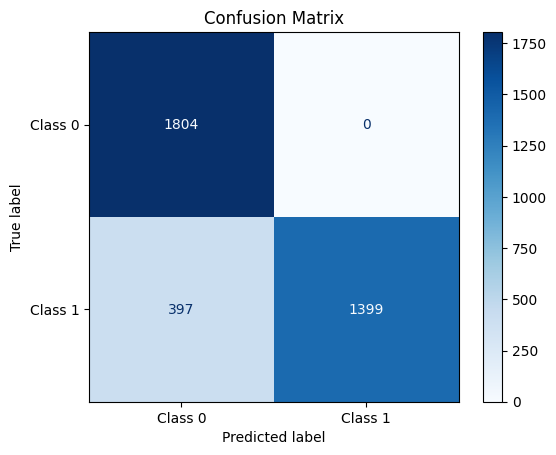

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 假设 predictions.label_ids 是真实的标签，preds 是模型的预测
cm = confusion_matrix(predictions.label_ids, preds)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [18]:
raw_datasets_dna_protein = load_dataset('json', data_files='dna_protein_150.json')['train'].train_test_split(test_size=0.05) #默认已经shuffle

In [19]:

tokenized_datasets_dna_protein = raw_datasets_dna_protein.map(tokenize_function, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 28099.24 examples/s]


In [20]:
predictions = trainer.predict(tokenized_datasets_dna_protein["test"])
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.52125, 'f1': 0.0}